# Running Totals in Window Functions 

### Introduction

So far, we saw how window functions can allow us to calculate aggregates over a specified group of rows -- which we call a window.  For example, to calculate the average number of transactions per store, we did so with the following: 

```sql
SELECT date, store_nbr, 
AVG(transactions) OVER (partition by store_nbr) as avg_transactions
FROM store_transactions
```

So once we get to the `OVER` keyword, we are defining the window (the grouping of rows).  In the above, that grouping is determined by the store number, calculating the average number of transactions per store.

In this lesson, we'll see how window functions can allow us to calculate running totals.  

### Loading our data

Let's again use the data from the [favorita kaggle competition](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data).

We begin by reading this data from a csv file.

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/data-eng-10-21/window-functions/main/favorita_transactions.csv"
df = pd.read_csv(url)
df[:2]

,id,date,store_nbr,transactions
0,0,2013-01-01,25,770
1,1,2013-01-02,1,2111


And then we can load this data into our database.

In [2]:
import sqlite3
conn = sqlite3.connect('grocery.db')

In [3]:
df.to_sql('store_transactions', conn, index = False, if_exists = 'replace')

### Reaching Sales Quotas

Let's take another look at our sales data.

In [7]:
pd.read_sql('SELECT * FROM store_transactions LIMIT 5', conn)

,id,date,store_nbr,transactions
0,0,2013-01-01,25,770
1,1,2013-01-02,1,2111
2,2,2013-01-02,2,2358
3,3,2013-01-02,3,3487
4,4,2013-01-02,4,1922


Now let's say that we want to use a window function to calculate the total amount sold by store.

In [14]:
query = """SELECT date, store_nbr, transactions,
SUM(transactions) OVER (partition by store_nbr) as total
FROM store_transactions 
 LIMIT 6"""

pd.read_sql(query, conn)

,date,store_nbr,transactions,total
0,2013-01-02,1,2111,2553963
1,2013-01-03,1,1833,2553963
2,2013-01-04,1,1863,2553963
3,2013-01-05,1,1509,2553963
4,2013-01-06,1,520,2553963
5,2013-01-07,1,1807,2553963


So currently we can see the transactions per store for a particular day compared to the total amount sold in that store across all days.  Now, if we manage one of these stores, we can imagine that we have quota to reach each month.  And to make sure that we are on track, it's useful to keep a running total.

With a running total, we add the amount sold in the current row to the amount sold in all previous rows sold in that group.  We can achieve that by adding an ORDER BY clause to our window function.  Let's see how. 

In [25]:
query = """SELECT date, store_nbr, transactions,
SUM(transactions) OVER (partition by store_nbr ORDER BY date) as running_total
FROM store_transactions 
 LIMIT 6"""

running_total_df = pd.read_sql(query, conn)
running_total_df

,date,store_nbr,transactions,running_total
0,2013-01-02,1,2111,2111
1,2013-01-03,1,1833,3944
2,2013-01-04,1,1863,5807
3,2013-01-05,1,1509,7316
4,2013-01-06,1,520,7836
5,2013-01-07,1,1807,9643


So focusing on the `running_total` column, we can see that store_1 sold 2111 products through day 1, 3944 through two days, and so on.  If the store were trying to hit ten sales in those first 6 days, it seems like it was on track until it hit the second to last day.

Calculating running totals can be particularly illustrative with plots.  Let's plot our running total with plotly.

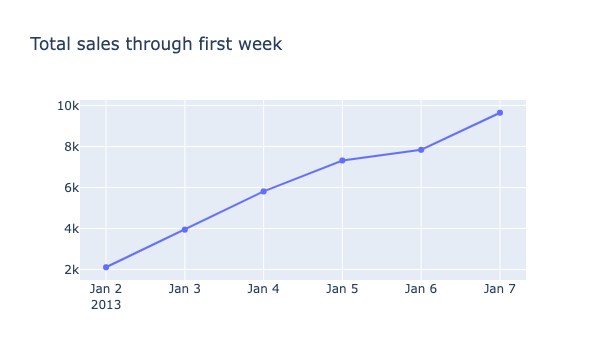

In [23]:
import plotly.graph_objects as go

running_total_scatter = go.Scatter(x = running_total_df.date, 
                                   y = running_total_df.running_total)
go.Figure(running_total_scatter, layout = dict(title = 'Total sales through first week'))

In the above, query we had to use both `partition by` and order by as we both create a window, and then calculate the running total per store.

```sql
SELECT date, store_nbr, transactions,
SUM(transactions) OVER (partition by store_nbr ORDER BY date) as running_total
FROM store_transactions 
```

However, we can create a running total by using by order by on it's own.  For example, this time we'll limit our dataset to just store one, and create a running total by just using the `ORDER BY` clause.

In [28]:
query = """SELECT date, store_nbr, transactions,
SUM(transactions) OVER (ORDER BY date) as running_total
FROM store_transactions 
WHERE store_nbr = 1
LIMIT 5"""
pd.read_sql(query, conn)

,date,store_nbr,transactions,running_total
0,2013-01-02,1,2111,2111
1,2013-01-03,1,1833,3944
2,2013-01-04,1,1863,5807
3,2013-01-05,1,1509,7316
4,2013-01-06,1,520,7836


See that? We didn't need to use partition by.  Rather simply using the `OVER` and then `ORDER BY` date, will calculate our running total.  Only if we want the running total to restart -- for example, for each store -- do we need to use the partition by. 

Let's try this one more time.  This time, we can pretend we are managing a group of stores, and want to see how each store is contributing to our daily quota.  We can do so with the following. 

In [60]:
query = """SELECT date, store_nbr, transactions,
SUM(transactions) OVER (PARTITION BY date ORDER BY transactions DESC) as running_total
FROM store_transactions 
LIMIT 100
"""
daily_quota_df = pd.read_sql(query, conn)

daily_quota_df[1:8]

,date,store_nbr,transactions,running_total
1,2013-01-02,46,4886,4886
2,2013-01-02,44,4821,9707
3,2013-01-02,45,4208,13915
4,2013-01-02,47,4161,18076
5,2013-01-02,11,3547,21623
6,2013-01-02,3,3487,25110
7,2013-01-02,48,3397,28507


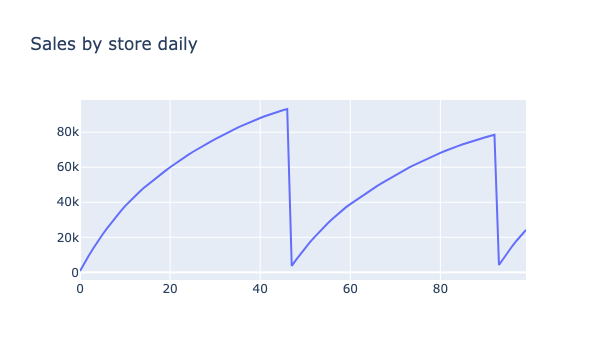

In [65]:
import plotly.graph_objects as go

running_total_scatter = go.Scatter(y = daily_quota_df.running_total, mode = 'lines')
go.Figure(running_total_scatter, layout = dict(title = 'Sales by store daily'))

So here we can see how each store contributed to our daily total, and we can see that we then start back at zero with each new day.  Notice that this plot also shows total sales per day, so we can see that we sold more on day one across all stores, than on day 2.

Also notice that we can order by whatever column we want.  So above, within each window, we ordered the stores by the number of transactions (most to least) within each window.

```SQL
SELECT date, store_nbr, transactions,
SUM(transactions) OVER (PARTITION BY date ORDER BY transactions DESC) as running_total
FROM store_transactions 
LIMIT 100
```

### Summary

In this lesson, we saw how we can use window functions to calculate running totals.  We did so by using the `ORDER BY` function.  Once we use order functions within the OVER clause, the window function calculates a running aggregate.  For example, when using the SUM function, we saw that it calculates a running total restarting at each window.  When using a running aggregate, we use the window function like so:

```sql
SUM(transactions) OVER (PARTITION BY date ORDER BY transactions DESC) as running_total
```

So we specify the aggregate function, the partition if any, and then how we would like the rows within each window ordered.